# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in various countries.

**The notebook pulls data from the Johns Hopkins [Data Repository](https://github.com/CSSEGISandData/COVID-19) of global Coronavirus COVID-19 cases**, and then does the following things:

- List cumulative number of confirmed cases (in countries with at least 100 confirmed cases)
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

We then repeat these steps for US states.

The notebook is updated approximately daily.

## Important Caveats:

- The confirmed cases reported by each country is different from the actual number of cases in each country (many of which are not tested). 

- Confirmed cases and actual cases grow at different rates. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but the actual cases may not be rising as the same rate.

- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')

## Global COVID-19 Analysis

In [3]:
cases = df.iloc[:,[1,-1]].groupby('Country/Region').sum()
mostrecentdate = cases.columns[0]
print('\nTotal number of cases (in countries with at least 100 cases) as of', mostrecentdate)

cases = cases.sort_values(by = mostrecentdate, ascending = False)
cases = cases[cases[mostrecentdate] >= 100]
cases


Total number of cases (in countries with at least 100 cases) as of 3/14/20


,3/14/20
Country/Region,
China,80977
Italy,21157
Iran,12729
"Korea, South",8086
Spain,6391
Germany,4585
France,4480
US,2727
Switzerland,1359


## Curve Fitting Global COVID-19 Cases

In [4]:
def logistic(t, a, b, c, d):
    return c + (d - c)/(1 + a * np.exp(- b * t))

def exponential(t, a, b, c):
    return a * np.exp(b * t) + c

def plotCases(dataframe, column, country):
    
    co = dataframe[dataframe[column] == country].iloc[:,4:].T.sum(axis = 1)
    co = pd.DataFrame(co)
    co.columns = ['Cases']
    co = co.loc[co['Cases'] > 0]
    
    y = np.array(co['Cases'])
    x = np.arange(y.size)
    
    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',co.index[-1],'\t',current)
            print('\tConfirmed cases on',co.index[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")
    
    logisticworked = False
    exponentialworked = False
    
    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=10000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            plt.plot(x, logistic(x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            logisticworked = True
    
    except:
        pass
    
    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0,-100],[100,0.9,100]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            plt.plot(x, exponential(x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            exponentialworked = True
            
    except:
        pass
    
    plt.title(country + ' Cumulative COVID-19 Cases. (Updated on '+mostrecentdate+')', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()
    
    if logisticworked and exponentialworked:
        if round(logisticr2,2) > round(expr2,2):
            return [ldoubletime, ldoubletimeerror, recentdbltime]
        else:
            return [edoubletime, edoubletimeerror, recentdbltime]
            
    if logisticworked:
        return [ldoubletime, ldoubletimeerror, recentdbltime]
    
    if exponentialworked:
        return [edoubletime, edoubletimeerror, recentdbltime]
    
    else:
        return [float('NaN'), float('NaN'), recentdbltime]



China

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 80977
	Confirmed cases on 3/7/20 	 80770
	Ratio: 1.0
	Weekly increase: 0.3 %
	Daily increase: 0.0 % per day
	Doubling Time (represents recent growth): 1895.7 days

** Based on Logistic Fit**

	R^2: 0.994970827446
	Doubling Time (during middle of growth):  6.46 (± 0.59 ) days


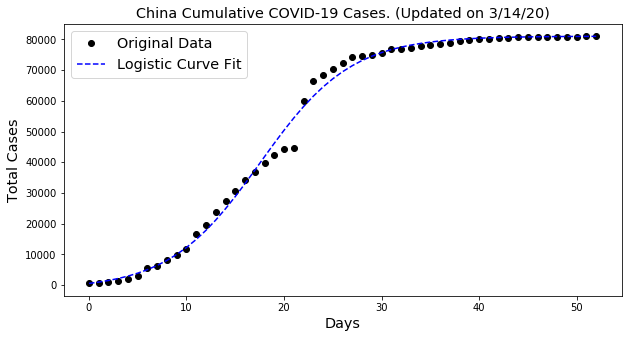



Italy

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 21157
	Confirmed cases on 3/7/20 	 5883
	Ratio: 3.6
	Weekly increase: 259.6 %
	Daily increase: 20.1 % per day
	Doubling Time (represents recent growth): 3.8 days

** Based on Logistic Fit**

	R^2: 0.994212346062
	Doubling Time (during middle of growth):  7.02 (± 1.07 ) days

** Based on Exponential Fit **

	R^2: 0.993987372589
	Doubling Time (represents overall growth):  3.73 (± 0.19 ) days


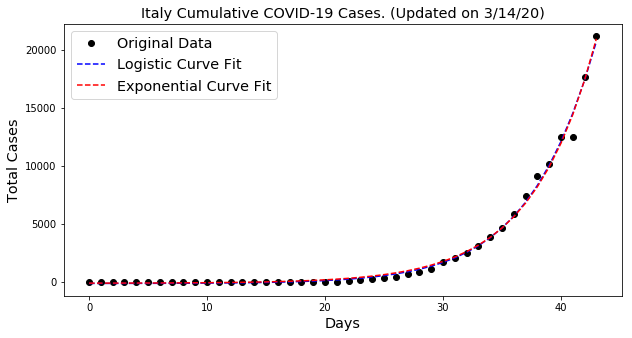



Iran

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 12729
	Confirmed cases on 3/7/20 	 5823
	Ratio: 2.19
	Weekly increase: 118.6 %
	Daily increase: 11.8 % per day
	Doubling Time (represents recent growth): 6.2 days

** Based on Logistic Fit**

	R^2: 0.995413658077
	Doubling Time (during middle of growth):  5.42 (± 0.93 ) days


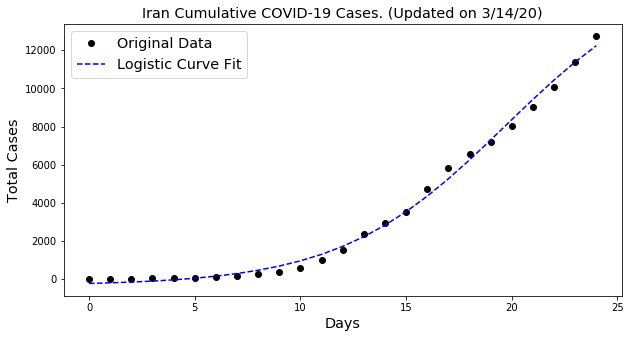



Korea, South

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 8086
	Confirmed cases on 3/7/20 	 7041
	Ratio: 1.15
	Weekly increase: 14.8 %
	Daily increase: 2.0 % per day
	Doubling Time (represents recent growth): 35.1 days

** Based on Logistic Fit**

	R^2: 0.999578956626
	Doubling Time (during middle of growth):  3.99 (± 0.11 ) days


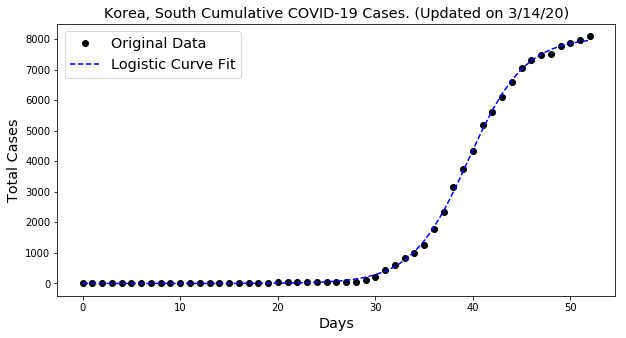



Spain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 6391
	Confirmed cases on 3/7/20 	 500
	Ratio: 12.78
	Weekly increase: 1178.2 %
	Daily increase: 43.9 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Exponential Fit **

	R^2: 0.981950997529
	Doubling Time (represents overall growth):  1.88 (± 0.16 ) days


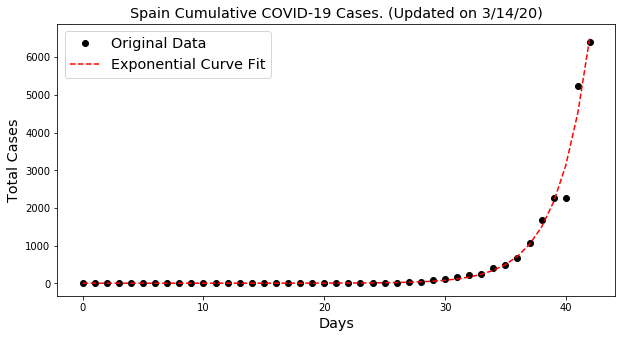



Germany

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 4585
	Confirmed cases on 3/7/20 	 799
	Ratio: 5.74
	Weekly increase: 473.8 %
	Daily increase: 28.4 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.989227919883
	Doubling Time (represents overall growth):  2.49 (± 0.16 ) days


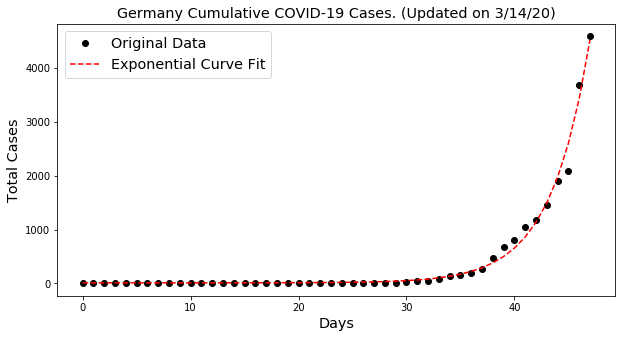



France

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 4480
	Confirmed cases on 3/7/20 	 952
	Ratio: 4.71
	Weekly increase: 370.6 %
	Daily increase: 24.8 % per day
	Doubling Time (represents recent growth): 3.1 days

** Based on Exponential Fit **

	R^2: 0.991840970433
	Doubling Time (represents overall growth):  2.79 (± 0.15 ) days


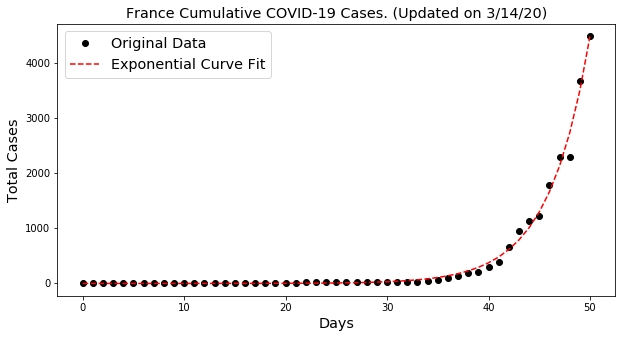



US

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 2727
	Confirmed cases on 3/7/20 	 402
	Ratio: 6.78
	Weekly increase: 578.4 %
	Daily increase: 31.5 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Exponential Fit **

	R^2: 0.99759296873
	Doubling Time (represents overall growth):  2.49 (± 0.07 ) days


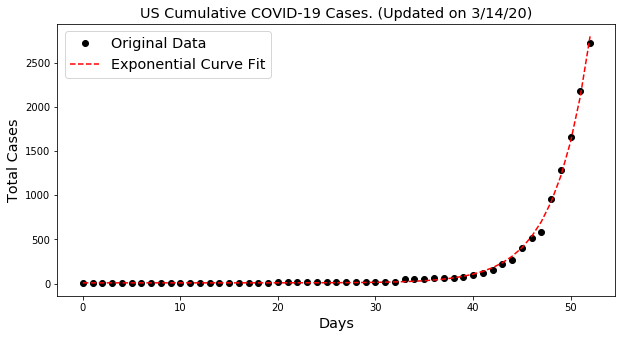



Switzerland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 1359
	Confirmed cases on 3/7/20 	 268
	Ratio: 5.07
	Weekly increase: 407.1 %
	Daily increase: 26.1 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Logistic Fit**

	R^2: 0.985200301307
	Doubling Time (during middle of growth):  5.58 (± 1.47 ) days

** Based on Exponential Fit **

	R^2: 0.985200302275
	Doubling Time (represents overall growth):  2.79 (± 0.41 ) days


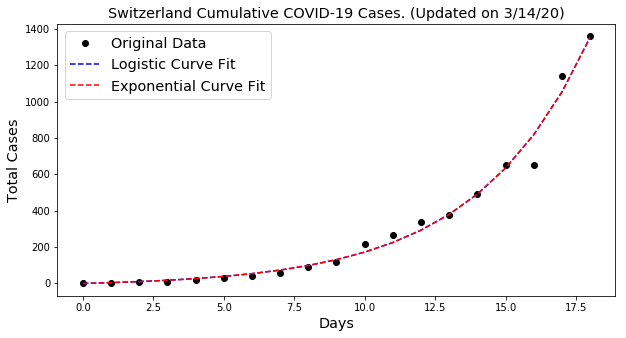



United Kingdom

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 1143
	Confirmed cases on 3/7/20 	 207
	Ratio: 5.52
	Weekly increase: 452.2 %
	Daily increase: 27.6 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.981215789343
	Doubling Time (represents overall growth):  2.55 (± 0.22 ) days


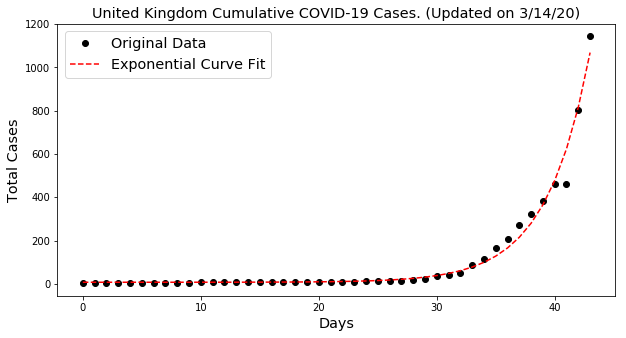



Norway

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 1090
	Confirmed cases on 3/7/20 	 147
	Ratio: 7.41
	Weekly increase: 641.5 %
	Daily increase: 33.1 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.992823453339
	Doubling Time (during middle of growth):  2.7 (± 0.65 ) days

** Based on Exponential Fit **

	R^2: 0.983398982215
	Doubling Time (represents overall growth):  2.68 (± 0.44 ) days


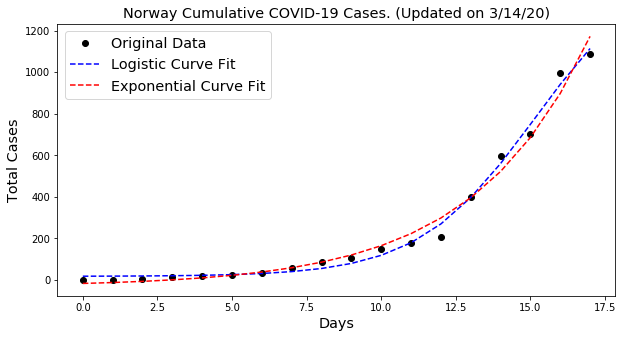



Sweden

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 961
	Confirmed cases on 3/7/20 	 161
	Ratio: 5.97
	Weekly increase: 496.9 %
	Daily increase: 29.1 % per day
	Doubling Time (represents recent growth): 2.7 days

** Based on Exponential Fit **

	R^2: 0.995101743545
	Doubling Time (represents overall growth):  2.64 (± 0.12 ) days


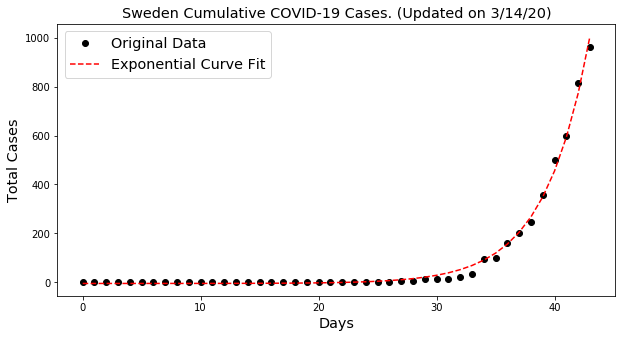



Netherlands

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 959
	Confirmed cases on 3/7/20 	 188
	Ratio: 5.1
	Weekly increase: 410.1 %
	Daily increase: 26.2 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Logistic Fit**

	R^2: 0.987678013871
	Doubling Time (during middle of growth):  6.47 (± 3.28 ) days

** Based on Exponential Fit **

	R^2: 0.987678014184
	Doubling Time (represents overall growth):  3.23 (± 0.53 ) days


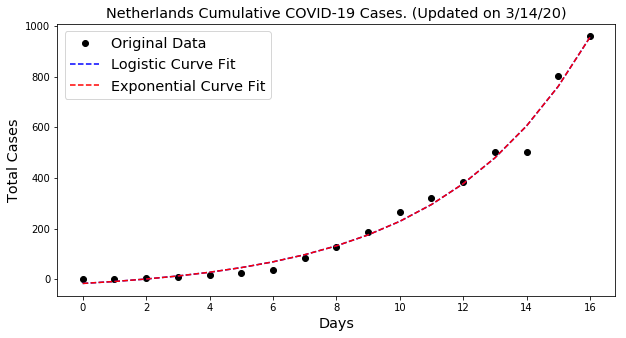



Denmark

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 836
	Confirmed cases on 3/7/20 	 24
	Ratio: 34.83
	Weekly increase: 3383.3 %
	Daily increase: 66.1 % per day
	Doubling Time (represents recent growth): 1.4 days

** Based on Logistic Fit**

	R^2: 0.998077629403
	Doubling Time (during middle of growth):  1.42 (± 0.16 ) days

** Based on Exponential Fit **

	R^2: 0.952149487314
	Doubling Time (represents overall growth):  2.4 (± 0.69 ) days


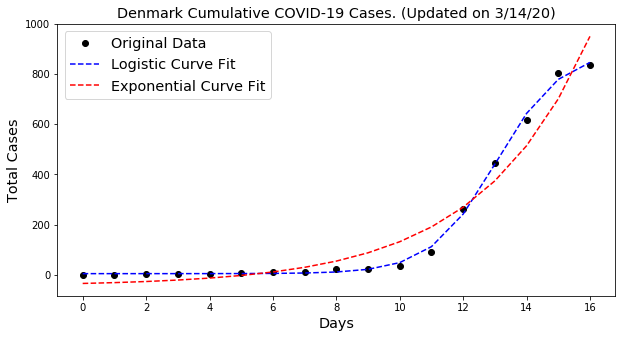



Japan

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 773
	Confirmed cases on 3/7/20 	 461
	Ratio: 1.68
	Weekly increase: 67.7 %
	Daily increase: 7.7 % per day
	Doubling Time (represents recent growth): 9.4 days

** Based on Logistic Fit**

	R^2: 0.997154303631
	Doubling Time (during middle of growth):  12.79 (± 1.35 ) days

** Based on Exponential Fit **

	R^2: 0.995848167322
	Doubling Time (represents overall growth):  8.45 (± 0.38 ) days


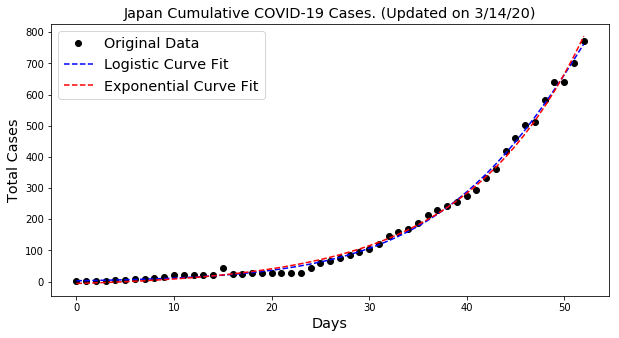



Cruise Ship

** Based on Logistic Fit**

	R^2: 0.995556816949
	Doubling Time (during middle of growth):  2.69 (± 0.3 ) days


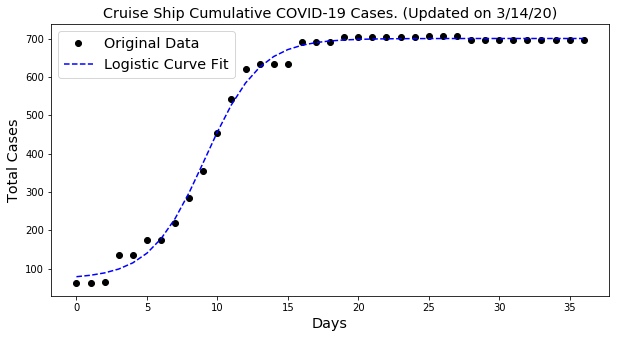



Belgium

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 689
	Confirmed cases on 3/7/20 	 169
	Ratio: 4.08
	Weekly increase: 307.7 %
	Daily increase: 22.2 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Exponential Fit **

	R^2: 0.977039507918
	Doubling Time (represents overall growth):  2.85 (± 0.29 ) days


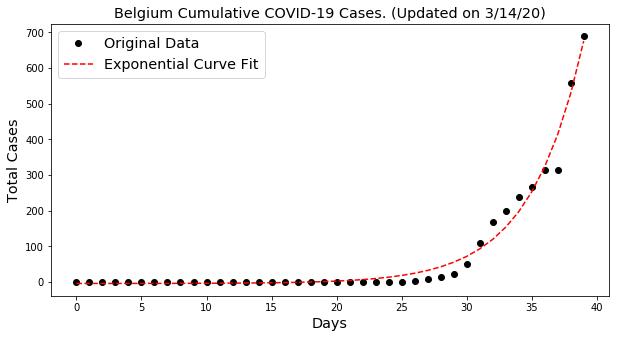



Austria

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 655
	Confirmed cases on 3/7/20 	 79
	Ratio: 8.29
	Weekly increase: 729.1 %
	Daily increase: 35.3 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.995327938032
	Doubling Time (during middle of growth):  4.21 (± 0.99 ) days

** Based on Exponential Fit **

	R^2: 0.995327938287
	Doubling Time (represents overall growth):  2.1 (± 0.16 ) days


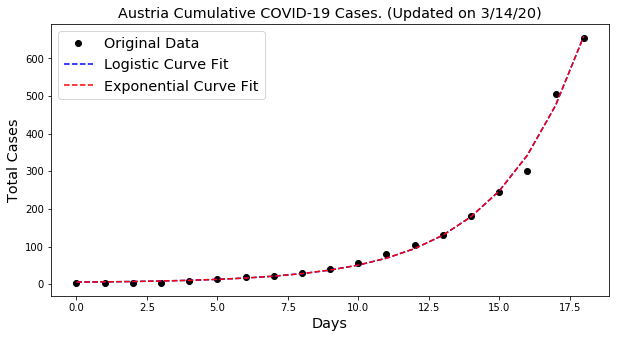



Qatar

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 337
	Confirmed cases on 3/7/20 	 8
	Ratio: 42.12
	Weekly increase: 4112.5 %
	Daily increase: 70.6 % per day
	Doubling Time (represents recent growth): 1.3 days

** Based on Logistic Fit**

	R^2: 0.986575843429
	Doubling Time (during middle of growth):  0.31 (± 0.16 ) days


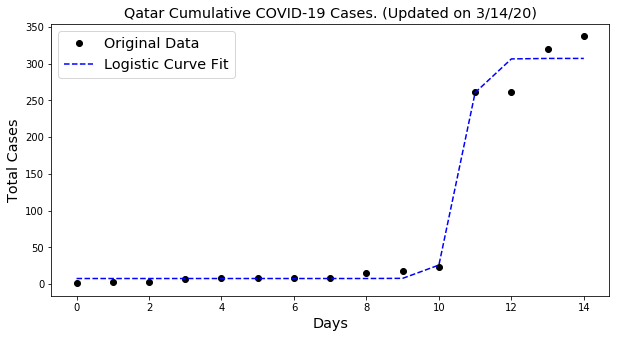



Australia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 250
	Confirmed cases on 3/7/20 	 63
	Ratio: 3.97
	Weekly increase: 296.8 %
	Daily increase: 21.8 % per day
	Doubling Time (represents recent growth): 3.5 days

** Based on Exponential Fit **

	R^2: 0.983400476343
	Doubling Time (represents overall growth):  3.27 (± 0.25 ) days


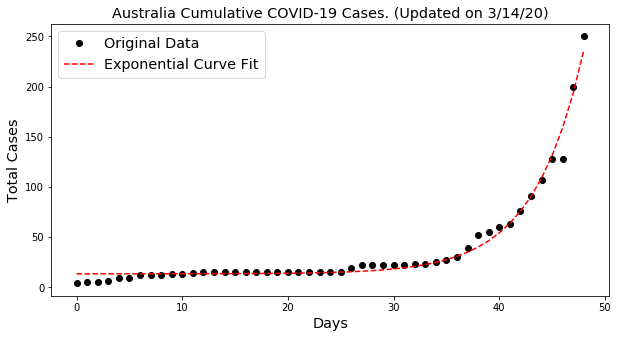



Malaysia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 238
	Confirmed cases on 3/7/20 	 93
	Ratio: 2.56
	Weekly increase: 155.9 %
	Daily increase: 14.4 % per day
	Doubling Time (represents recent growth): 5.2 days

** Based on Exponential Fit **

	R^2: 0.981667934798
	Doubling Time (represents overall growth):  4.14 (± 0.34 ) days


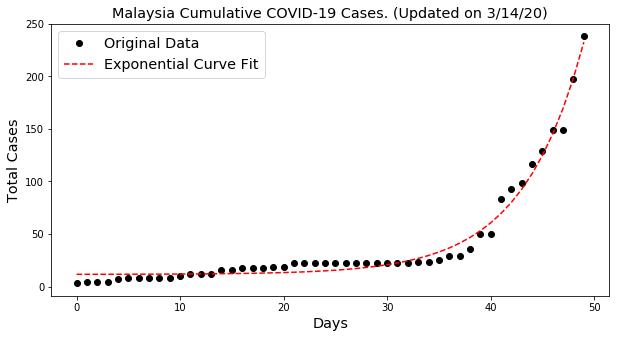



Greece

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 228
	Confirmed cases on 3/7/20 	 46
	Ratio: 4.96
	Weekly increase: 395.7 %
	Daily increase: 25.7 % per day
	Doubling Time (represents recent growth): 3.0 days

** Based on Logistic Fit**

	R^2: 0.963029968919
	Doubling Time (during middle of growth):  5.96 (± 4.01 ) days

** Based on Exponential Fit **

	R^2: 0.963029971038
	Doubling Time (represents overall growth):  2.98 (± 0.77 ) days


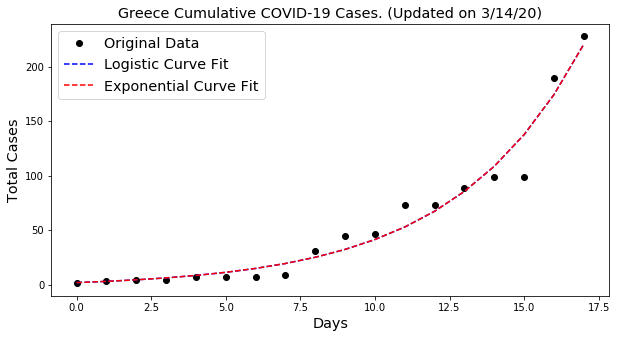



Finland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 225
	Confirmed cases on 3/7/20 	 15
	Ratio: 15.0
	Weekly increase: 1400.0 %
	Daily increase: 47.2 % per day
	Doubling Time (represents recent growth): 1.8 days

** Based on Exponential Fit **

	R^2: 0.981210263407
	Doubling Time (represents overall growth):  1.47 (± 0.13 ) days


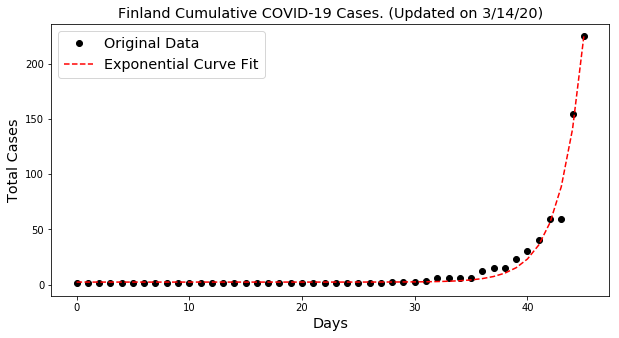



Singapore

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 212
	Confirmed cases on 3/7/20 	 138
	Ratio: 1.54
	Weekly increase: 53.6 %
	Daily increase: 6.3 % per day
	Doubling Time (represents recent growth): 11.3 days

** Based on Logistic Fit**

	R^2: 0.971765607561
	Doubling Time (during middle of growth):  52.42 (± 28.0 ) days

** Based on Exponential Fit **

	R^2: 0.971765609019
	Doubling Time (represents overall growth):  26.21 (± 7.37 ) days


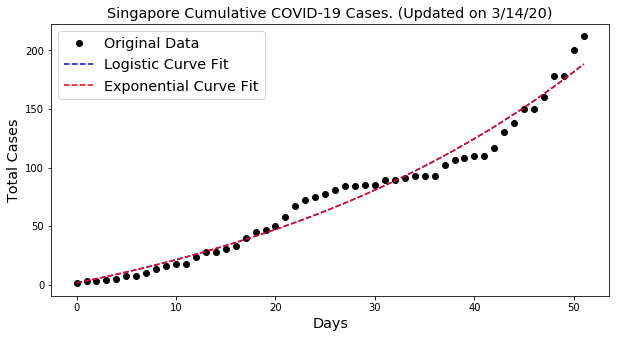



Bahrain

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 210
	Confirmed cases on 3/7/20 	 85
	Ratio: 2.47
	Weekly increase: 147.1 %
	Daily increase: 13.8 % per day
	Doubling Time (represents recent growth): 5.4 days


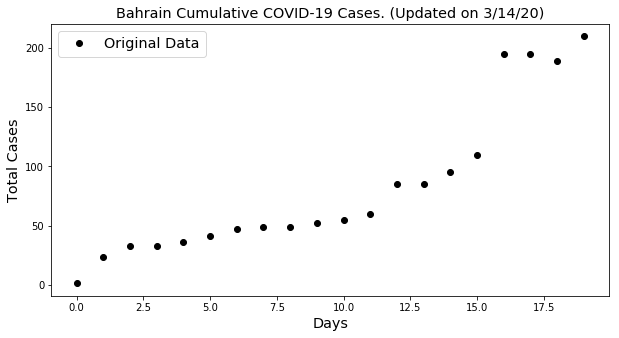



Canada

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 198
	Confirmed cases on 3/7/20 	 54
	Ratio: 3.67
	Weekly increase: 266.7 %
	Daily increase: 20.4 % per day
	Doubling Time (represents recent growth): 3.7 days

** Based on Exponential Fit **

	R^2: 0.983672413989
	Doubling Time (represents overall growth):  3.38 (± 0.26 ) days


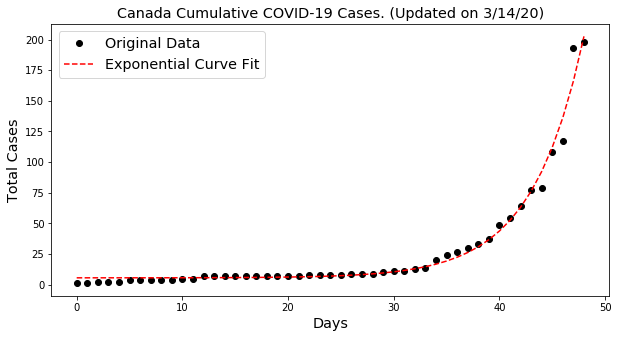



Israel

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 193
	Confirmed cases on 3/7/20 	 43
	Ratio: 4.49
	Weekly increase: 348.8 %
	Daily increase: 23.9 % per day
	Doubling Time (represents recent growth): 3.2 days

** Based on Logistic Fit**

	R^2: 0.997221571055
	Doubling Time (during middle of growth):  5.12 (± 0.84 ) days

** Based on Exponential Fit **

	R^2: 0.995970969065
	Doubling Time (represents overall growth):  3.32 (± 0.23 ) days


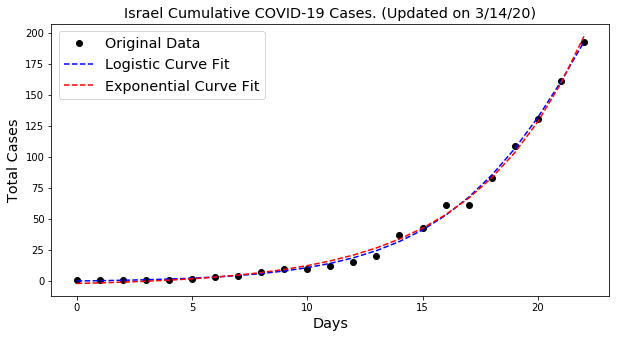



Czechia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 189
	Confirmed cases on 3/7/20 	 19
	Ratio: 9.95
	Weekly increase: 894.7 %
	Daily increase: 38.8 % per day
	Doubling Time (represents recent growth): 2.1 days

** Based on Logistic Fit**

	R^2: 0.98648868446
	Doubling Time (during middle of growth):  3.74 (± 2.27 ) days

** Based on Exponential Fit **

	R^2: 0.986233277251
	Doubling Time (represents overall growth):  2.17 (± 0.39 ) days


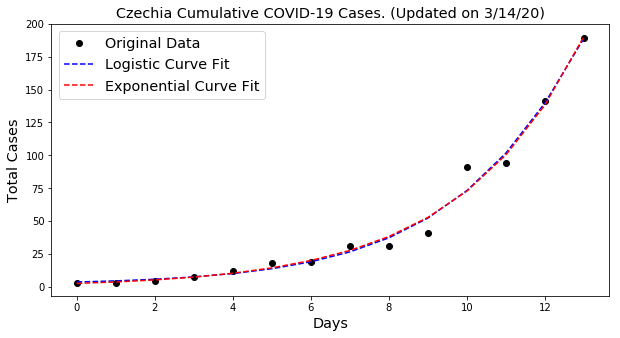



Slovenia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 181
	Confirmed cases on 3/7/20 	 7
	Ratio: 25.86
	Weekly increase: 2485.7 %
	Daily increase: 59.1 % per day
	Doubling Time (represents recent growth): 1.5 days

** Based on Logistic Fit**

	R^2: 0.998229345509
	Doubling Time (during middle of growth):  1.85 (± 0.36 ) days

** Based on Exponential Fit **

	R^2: 0.990057873799
	Doubling Time (represents overall growth):  1.93 (± 0.41 ) days


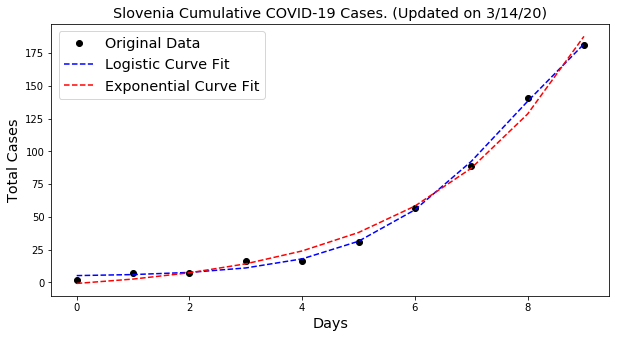



Portugal

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 169
	Confirmed cases on 3/7/20 	 20
	Ratio: 8.45
	Weekly increase: 745.0 %
	Daily increase: 35.6 % per day
	Doubling Time (represents recent growth): 2.3 days

** Based on Logistic Fit**

	R^2: 0.97970086768
	Doubling Time (during middle of growth):  3.45 (± 0.49 ) days

** Based on Exponential Fit **

	R^2: 0.979700868561
	Doubling Time (represents overall growth):  1.72 (± 0.37 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


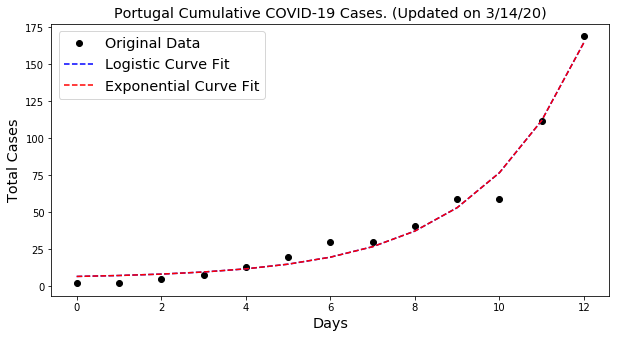



Iceland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 156
	Confirmed cases on 3/7/20 	 50
	Ratio: 3.12
	Weekly increase: 212.0 %
	Daily increase: 17.7 % per day
	Doubling Time (represents recent growth): 4.3 days

** Based on Logistic Fit**

	R^2: 0.986227106834
	Doubling Time (during middle of growth):  9.06 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.986227107515
	Doubling Time (represents overall growth):  4.53 (± 1.06 ) days


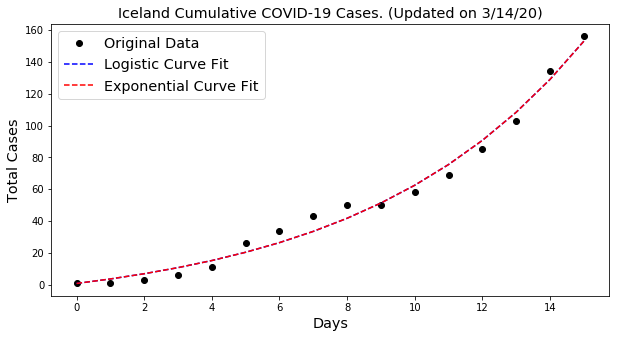



Brazil

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 151
	Confirmed cases on 3/7/20 	 13
	Ratio: 11.62
	Weekly increase: 1061.5 %
	Daily increase: 42.0 % per day
	Doubling Time (represents recent growth): 2.0 days


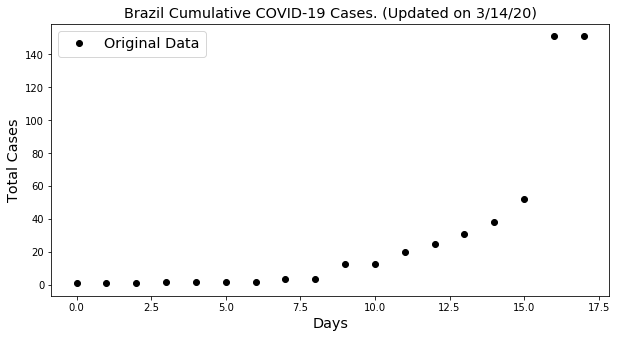



Ireland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 129
	Confirmed cases on 3/7/20 	 18
	Ratio: 7.17
	Weekly increase: 616.7 %
	Daily increase: 32.5 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.972935950939
	Doubling Time (during middle of growth):  3.48 (± 1.05 ) days

** Based on Exponential Fit **

	R^2: 0.972935951893
	Doubling Time (represents overall growth):  1.74 (± 0.38 ) days


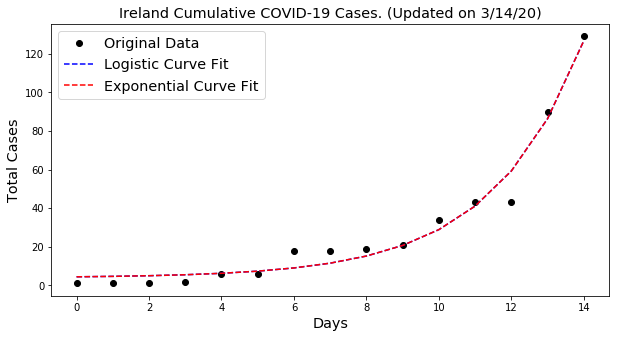



Romania

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 123
	Confirmed cases on 3/7/20 	 9
	Ratio: 13.67
	Weekly increase: 1266.7 %
	Daily increase: 45.3 % per day
	Doubling Time (represents recent growth): 1.9 days

** Based on Exponential Fit **

	R^2: 0.992072313395
	Doubling Time (represents overall growth):  1.73 (± 0.17 ) days


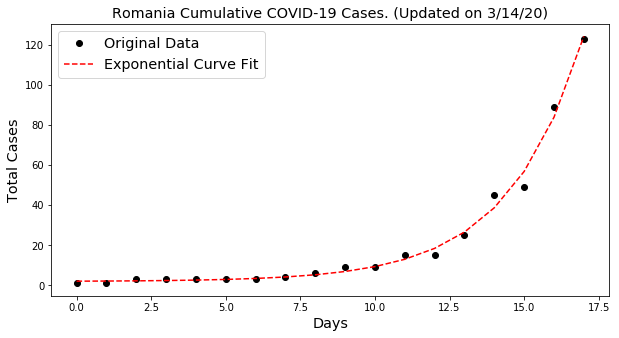



Estonia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 115
	Confirmed cases on 3/7/20 	 10
	Ratio: 11.5
	Weekly increase: 1050.0 %
	Daily increase: 41.8 % per day
	Doubling Time (represents recent growth): 2.0 days

** Based on Exponential Fit **

	R^2: 0.952898561314
	Doubling Time (represents overall growth):  1.04 (± 0.27 ) days


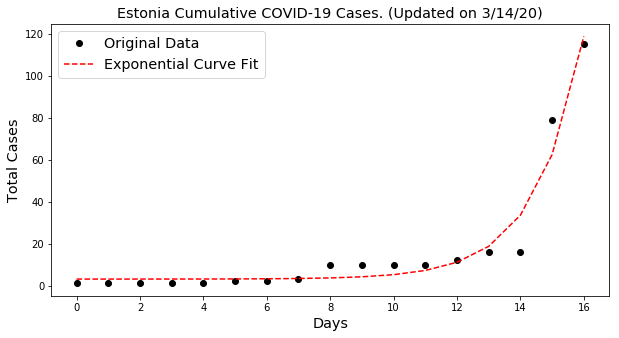



Philippines

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 111
	Confirmed cases on 3/7/20 	 6
	Ratio: 18.5
	Weekly increase: 1750.0 %
	Daily increase: 51.7 % per day
	Doubling Time (represents recent growth): 1.7 days

** Based on Exponential Fit **

	R^2: 0.979496648484
	Doubling Time (represents overall growth):  1.92 (± 0.17 ) days


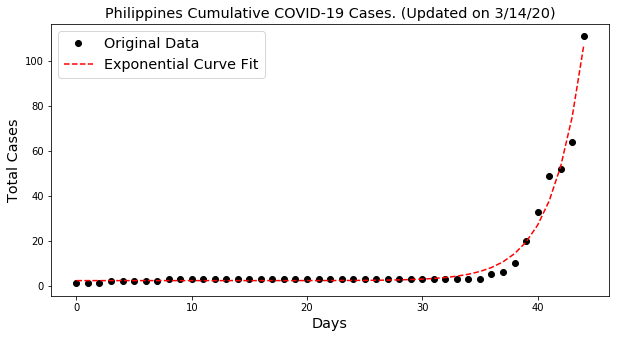



Iraq

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 110
	Confirmed cases on 3/7/20 	 54
	Ratio: 2.04
	Weekly increase: 103.7 %
	Daily increase: 10.7 % per day
	Doubling Time (represents recent growth): 6.8 days

** Based on Logistic Fit**

	R^2: 0.977486342799
	Doubling Time (during middle of growth):  19.38 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.977486344422
	Doubling Time (represents overall growth):  9.69 (± 3.99 ) days


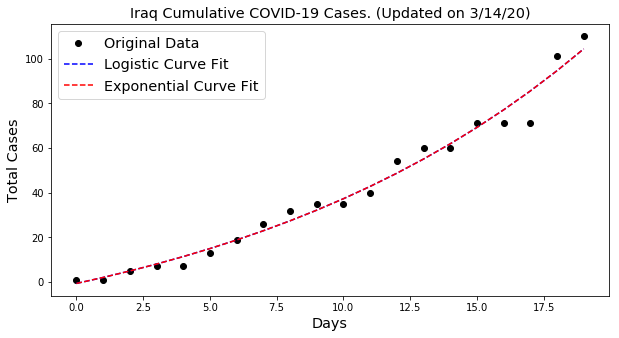



Egypt

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 109
	Confirmed cases on 3/7/20 	 15
	Ratio: 7.27
	Weekly increase: 626.7 %
	Daily increase: 32.8 % per day
	Doubling Time (represents recent growth): 2.4 days

** Based on Logistic Fit**

	R^2: 0.959872360748
	Doubling Time (during middle of growth):  3.27 (± 1.27 ) days


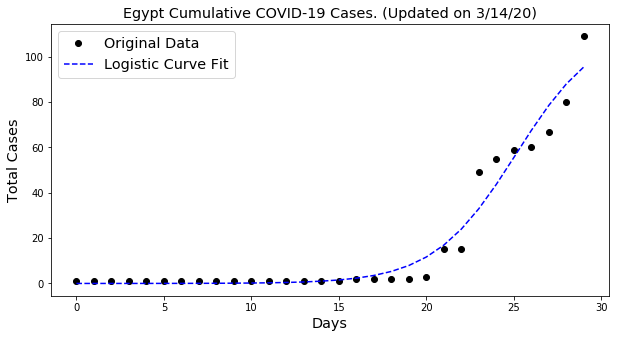



Kuwait

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 104
	Confirmed cases on 3/7/20 	 61
	Ratio: 1.7
	Weekly increase: 70.5 %
	Daily increase: 7.9 % per day
	Doubling Time (represents recent growth): 9.1 days


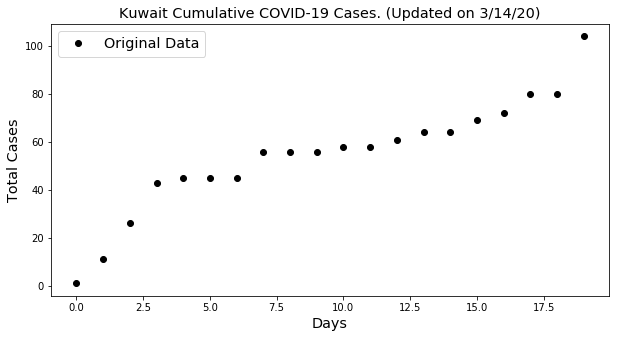



Poland

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 103
	Confirmed cases on 3/7/20 	 5
	Ratio: 20.6
	Weekly increase: 1960.0 %
	Daily increase: 54.1 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Logistic Fit**

	R^2: 0.998502009809
	Doubling Time (during middle of growth):  3.7 (± 0.27 ) days

** Based on Exponential Fit **

	R^2: 0.998502009865
	Doubling Time (represents overall growth):  1.85 (± 0.13 ) days


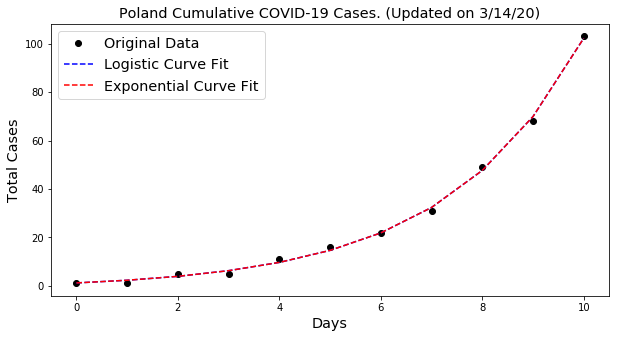



Saudi Arabia

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 103
	Confirmed cases on 3/7/20 	 5
	Ratio: 20.6
	Weekly increase: 1960.0 %
	Daily increase: 54.1 % per day
	Doubling Time (represents recent growth): 1.6 days

** Based on Logistic Fit**

	R^2: 0.982053401863
	Doubling Time (during middle of growth):  1.48 (± 0.69 ) days

** Based on Exponential Fit **

	R^2: 0.97318257271
	Doubling Time (represents overall growth):  1.67 (± 0.41 ) days


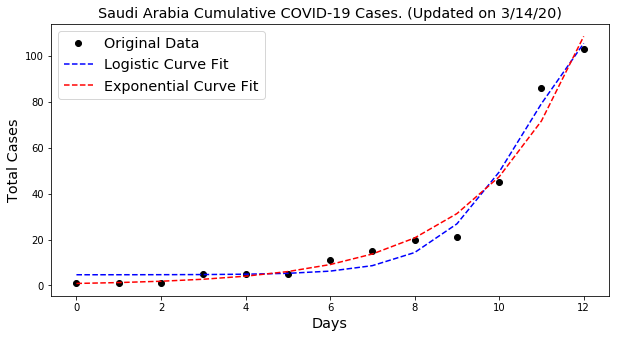



India

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 102
	Confirmed cases on 3/7/20 	 34
	Ratio: 3.0
	Weekly increase: 200.0 %
	Daily increase: 17.0 % per day
	Doubling Time (represents recent growth): 4.4 days

** Based on Exponential Fit **

	R^2: 0.975888014222
	Doubling Time (represents overall growth):  3.92 (± 0.4 ) days


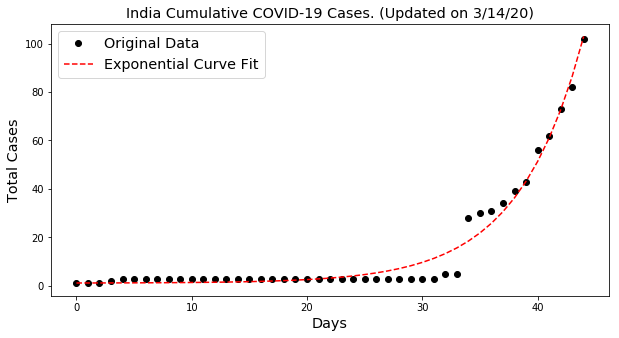

In [5]:
topcountries = cases.index
inferreddoublingtime = []
recentdoublingtime = []
errors = []
countries = []
print('\n')

for c in topcountries:
    print(c)
    a = plotCases(df, 'Country/Region', c)
    if a:
        countries.append(c)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for Global COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


         Countries  Inferred Doubling Time  Recent Doubling Time
0            China                     6.5                1895.7
1            Italy                     3.7                   3.8
2             Iran                     5.4                   6.2
3     Korea, South                     4.0                  35.1
4            Spain                     1.9                   1.9
5          Germany                     2.5                   2.8
6           France                     2.8                   3.1
7               US                     2.5                   2.5
8      Switzerland                     2.8                   3.0
9   United Kingdom                     2.6                   2.8
10          Norway                     2.7                   2.4
11          

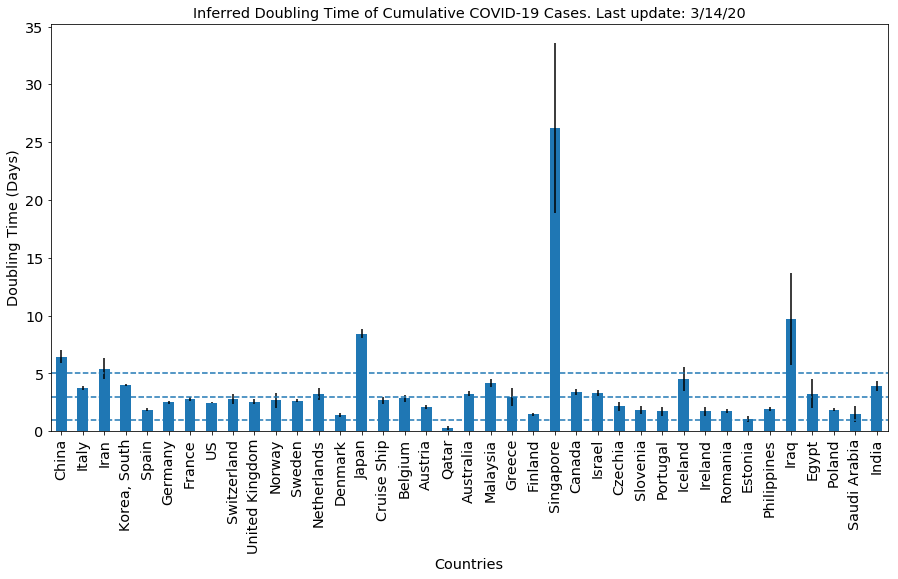

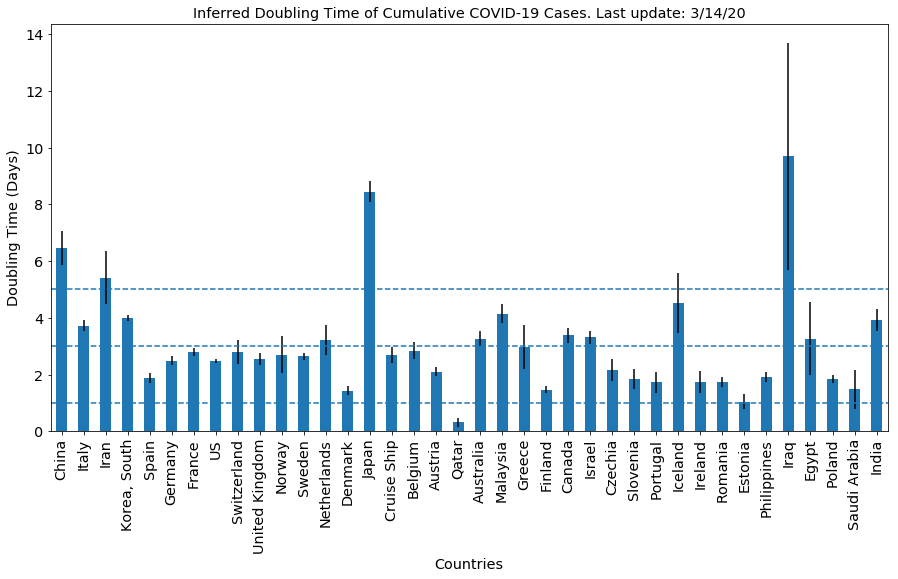

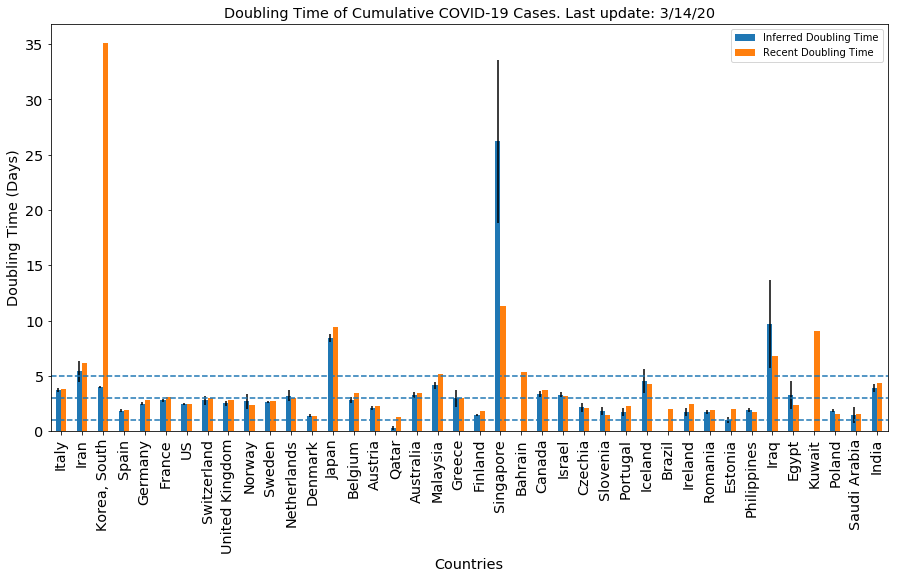

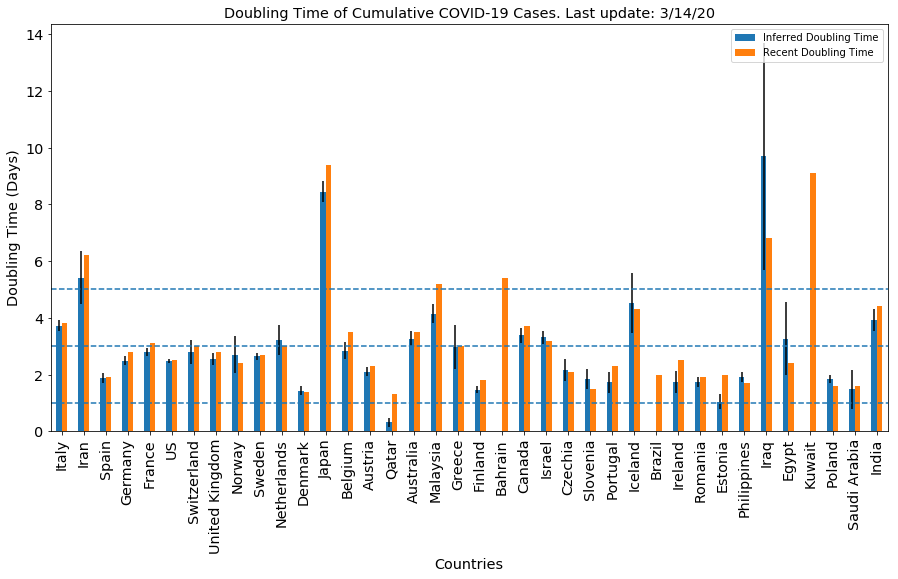

In [6]:
d = {'Countries': countries, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')

print(pd.DataFrame(data=d).iloc[:,[1,2,3]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 10]
dt.plot.bar(x = 'Countries', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(15,7.5), fontsize="x-large");
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=countries
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=countries)
dt = dt[dt['Recent Doubling Time'] < 10]
dt.plot.bar(figsize=(15,7.5), fontsize="x-large", yerr=err)
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('Countries', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

## US COVID-19 Analysis

In [7]:
uscases = df[df['Country/Region'] == 'US'].copy()

# US states lookup from https://code.activestate.com/recipes/577305-python-dictionary-of-us-states-and-territories/
# with DC added
states = { 'AK': 'Alaska', 'AL': 'Alabama', 'AR': 'Arkansas', 'AS': 'American Samoa', 'AZ': 'Arizona', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DC': 'District of Columbia', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts', 'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota', 'MO': 'Missouri', 'MP': 'Northern Mariana Islands', 'MS': 'Mississippi', 'MT': 'Montana', 'NA': 'National', 'NC': 'North Carolina', 'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'PR': 'Puerto Rico', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia', 'VI': 'Virgin Islands', 'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming', 'D.C.': 'District of Columbia'}

for index, row in uscases.iterrows():
    location = row['Province/State']
    try:
        if ',' in location:
            result = [x.strip() for x in location.split(',')]
            statename = states[result[1]]
            row['State'] = statename
            uscases.loc[index, 'Province/State'] = statename
    except:
        print('Error parsing US state:', location)        
            
usstatesummary = uscases.iloc[:,[0,-1]].groupby('Province/State').sum()
mostrecentdate = usstatesummary.columns[0]
usstatesummary = usstatesummary.sort_values(by = mostrecentdate, ascending = False)
usstatesummary = usstatesummary[usstatesummary[mostrecentdate] > 0]

print('\nNumber of confirmed US COVID-19 cases by state as of', mostrecentdate)
usstatesummary

Error parsing US state: Virgin Islands, U.S.

Number of confirmed US COVID-19 cases by state as of 3/14/20


,3/14/20
Province/State,
Washington,572
New York,525
California,340
Massachusetts,138
Colorado,101
Louisiana,77
Florida,76
New Jersey,69
Georgia,66


## Curve Fitting US COVID-19 Cases

                3/14/20
Province/State         
Washington          572
New York            525
California          340
Massachusetts       138
Colorado            101


US state:  Washington

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 572
	Confirmed cases on 3/7/20 	 102
	Ratio: 5.61
	Weekly increase: 460.8 %
	Daily increase: 27.9 % per day
	Doubling Time (represents recent growth): 2.8 days

** Based on Exponential Fit **

	R^2: 0.976458300602
	Doubling Time (represents overall growth):  2.84 (± 0.25 ) days


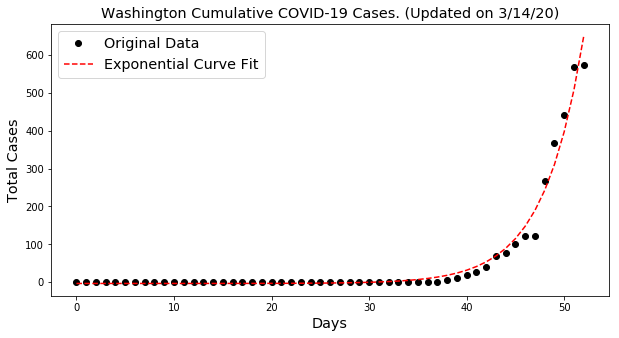



US state:  New York

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 525
	Confirmed cases on 3/7/20 	 76
	Ratio: 6.91
	Weekly increase: 590.8 %
	Daily increase: 31.8 % per day
	Doubling Time (represents recent growth): 2.5 days

** Based on Logistic Fit**

	R^2: 0.996559035617
	Doubling Time (during middle of growth):  4.94 (± 2.21 ) days

** Based on Exponential Fit **

	R^2: 0.996390630195
	Doubling Time (represents overall growth):  2.9 (± 0.34 ) days


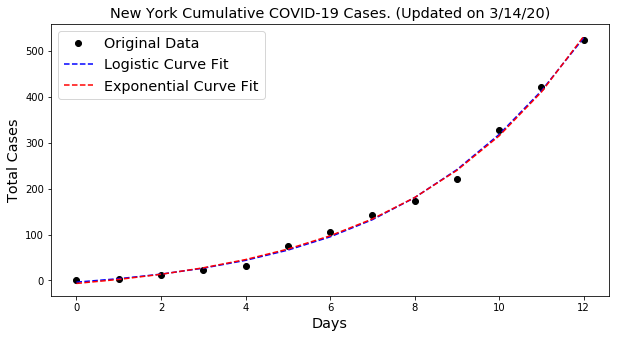



US state:  California

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 340
	Confirmed cases on 3/7/20 	 81
	Ratio: 4.2
	Weekly increase: 319.8 %
	Daily increase: 22.7 % per day
	Doubling Time (represents recent growth): 3.4 days

** Based on Exponential Fit **

	R^2: 0.997275813747
	Doubling Time (represents overall growth):  3.0 (± 0.09 ) days


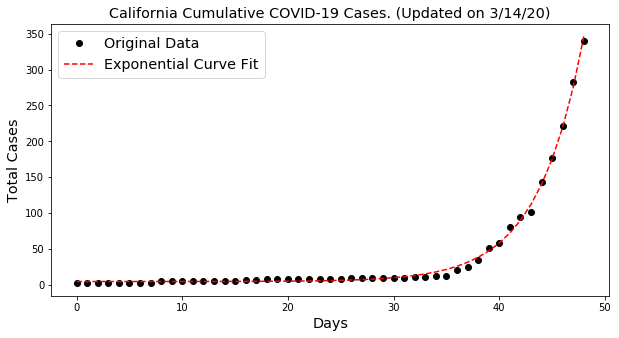



US state:  Massachusetts

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 138
	Confirmed cases on 3/7/20 	 6
	Ratio: 23.0
	Weekly increase: 2200.0 %
	Daily increase: 56.5 % per day
	Doubling Time (represents recent growth): 1.5 days


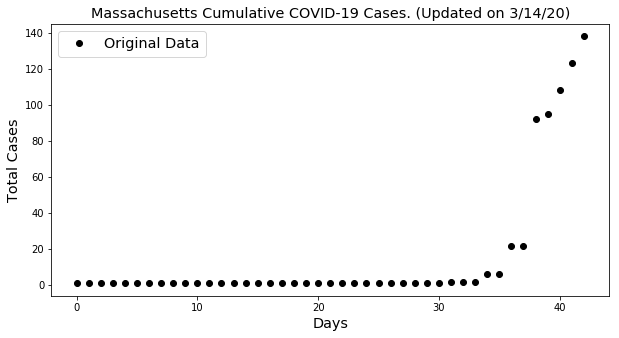



US state:  Colorado

** Based on Most Recent Week of Data **

	Confirmed cases on 3/14/20 	 101
	Confirmed cases on 3/7/20 	 7
	Ratio: 14.43
	Weekly increase: 1342.9 %
	Daily increase: 46.4 % per day
	Doubling Time (represents recent growth): 1.8 days

** Based on Logistic Fit**

	R^2: 0.962847686122
	Doubling Time (during middle of growth):  2.98 (± nan ) days

** Based on Exponential Fit **

	R^2: 0.962847687433
	Doubling Time (represents overall growth):  1.49 (± 0.63 ) days


/Users/aatish/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in sqrt


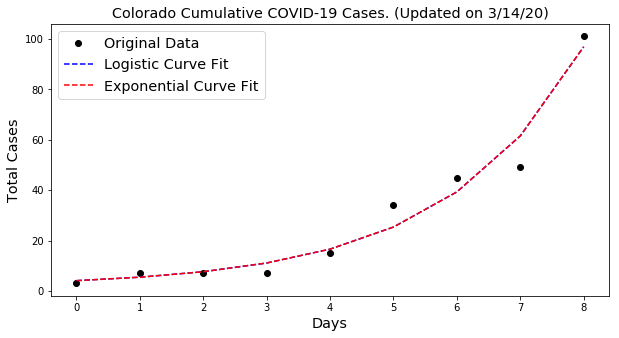

In [8]:
topusstates = usstatesummary[usstatesummary[mostrecentdate] >= 100]
print(topusstates)

print('\n');
inferreddoublingtime = []
recentdoublingtime = []
errors = []
states = []

for state in topusstates.index.values:
    print('US state: ', state)
    a = plotCases(uscases,'Province/State', state)
    if a:
        states.append(state)
        inferreddoublingtime.append(a[0])
        errors.append(a[1])
        recentdoublingtime.append(a[2])
    print('\n')

## Doubling Times for US COVID-19 Cases


Inferred Doubling Times are inferred using curve fits.
Recent Doubling Times are calculated using the most recent week of data.
Shorter doubling time = faster growth, longer doubling time = slower growth.


          States  Inferred Doubling Time  Recent Doubling Time
0     Washington                     2.8                   2.8
1       New York                     2.9                   2.5
2     California                     3.0                   3.4
3  Massachusetts                     NaN                   1.5
4       Colorado                     1.5                   1.8




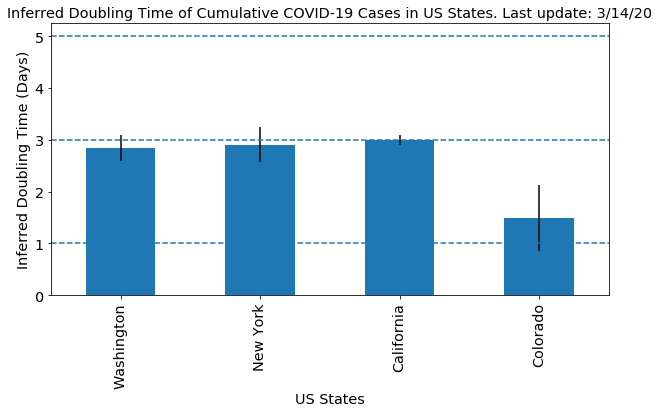

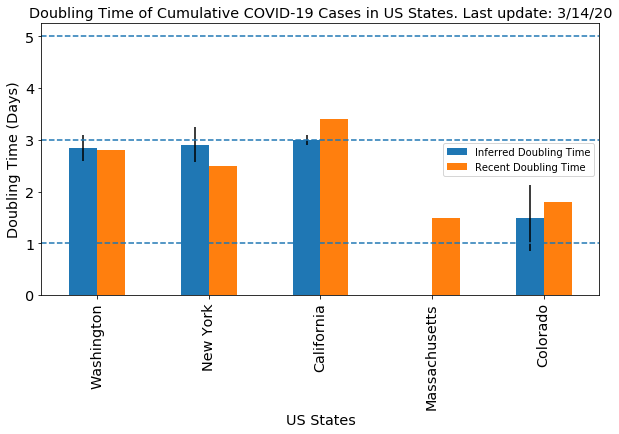

In [9]:
d = {'States': states, 'Inferred Doubling Time': inferreddoublingtime, '95%CI': errors, 'Recent Doubling Time': recentdoublingtime}

print('\nInferred Doubling Times are inferred using curve fits.') 
print('Recent Doubling Times are calculated using the most recent week of data.')
print('Shorter doubling time = faster growth, longer doubling time = slower growth.')
print('\n')
print(pd.DataFrame(data=d).iloc[:,[3,1,2]].round(1))    

print('\n')
dt = pd.DataFrame(data = d)
dt = dt[dt['Inferred Doubling Time'] < 100]
dt.plot.bar(x = 'States', y = 'Inferred Doubling Time', yerr='95%CI', legend=False,figsize=(10,5), fontsize="x-large");
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.ylabel('Inferred Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.title('Inferred Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()

err = pd.DataFrame([errors,[float('NaN') for e in errors]]).T
err.index=states
err.columns = ['Inferred Doubling Time', 'Recent Doubling Time']

print('\n')
dt = pd.DataFrame({'Inferred Doubling Time': inferreddoublingtime,'Recent Doubling Time': recentdoublingtime}, index=states)
dt = dt[dt['Recent Doubling Time'] < 100]
dt.plot.bar(yerr=err, figsize=(10,5), fontsize="x-large")
plt.ylabel('Doubling Time (Days)', fontsize="x-large")
plt.xlabel('US States', fontsize="x-large")
plt.axhline(y=1, linestyle='--')
plt.axhline(y=3, linestyle='--')
plt.axhline(y=5, linestyle='--')
plt.title('Doubling Time of Cumulative COVID-19 Cases in US States. Last update: ' + mostrecentdate, fontsize="x-large")
plt.show()